In [3]:
%pylab inline
import GPyOpt
import GPy

Populating the interactive namespace from numpy and matplotlib


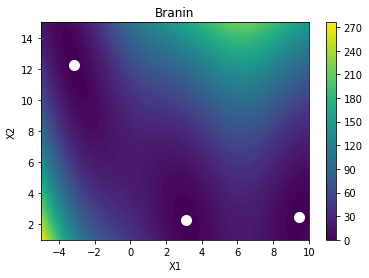

In [4]:
# --- Function to optimize
func  = GPyOpt.objective_examples.experiments2d.branin()
func.plot()

In [5]:
objective = GPyOpt.core.task.SingleObjective(func.f)

In [6]:
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])

In [7]:
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

In [8]:
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

In [9]:
initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

In [16]:
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.acquisitions.EI import AcquisitionEI
from numpy.random import beta

class jitter_integrated_EI(AcquisitionBase):
    
    analytical_gradient_prediction = True
    
    def __init__(self, model, space, optimizer=None, cost_withGradients=None, par_a=1, par_b=1, num_samples= 10):
        super(jitter_integrated_EI, self).__init__(model, space, optimizer)
        
        self.par_a = par_a
        self.par_b = par_b
        self.num_samples = num_samples
        self.samples = beta(self.par_a,self.par_b,self.num_samples)
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)
    
    def acquisition_function(self,x):
        acqu_x = np.zeros((x.shape[0],1))       
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]
            acqu_x +=self.EI.acquisition_function(x)           
        return acqu_x/self.num_samples
    
    def acquisition_function_withGradients(self,x):
        acqu_x      = np.zeros((x.shape[0],1))       
        acqu_x_grad = np.zeros(x.shape)
        
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]       
            acqu_x_sample, acqu_x_grad_sample = self.EI.acquisition_function_withGradients(x) 
            acqu_x += acqu_x_sample
            acqu_x_grad += acqu_x_grad_sample           
        return acqu_x/self.num_samples, acqu_x_grad/self.num_samples

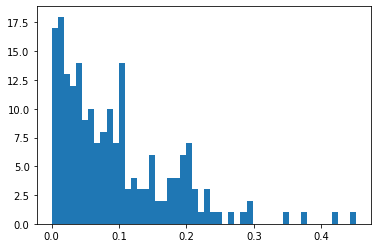

In [17]:
acquisition = jitter_integrated_EI(model, space, optimizer=aquisition_optimizer, par_a=1, par_b=10, num_samples=200)
xx = plt.hist(acquisition.samples,bins=50)

In [18]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [19]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)

In [ ]:
max_iter  = 10                                            
bo.run_optimization(max_iter = max_iter,verbosity = True) 

num acquisition: 1, time elapsed: 218.61s
num acquisition: 2, time elapsed: 444.40s
num acquisition: 3, time elapsed: 723.57s
num acquisition: 4, time elapsed: 943.28s
num acquisition: 5, time elapsed: 1059.11s
num acquisition: 6, time elapsed: 1184.64s
num acquisition: 7, time elapsed: 1551.24s
num acquisition: 8, time elapsed: 1942.49s


In [ ]:
bo.plot_acquisition()
bo.plot_convergence()